In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, log_loss
)
from imblearn.over_sampling import SMOTE

In [3]:
df=pd.read_csv(r'predictive_maintenance.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [5]:
print("\nSummary Statistics:")
df.describe()


Summary Statistics:


,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [6]:
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64


In [7]:
target_counts = df['Target'].value_counts().reset_index()
target_counts.columns = ['Target', 'Count']
print("\nTarget Variable Counts:")
print(tabulate(target_counts, headers='keys', tablefmt='fancy_grid'))


Target Variable Counts:
╒════╤══════════╤═════════╕
│    │   Target │   Count │
╞════╪══════════╪═════════╡
│  0 │        0 │    9661 │
├────┼──────────┼─────────┤
│  1 │        1 │     339 │
╘════╧══════════╧═════════╛


In [8]:
print("\nUnique Failure Types:")
print(", ".join(df['Failure Type'].unique()))
failure_counts = df['Failure Type'].value_counts().reset_index()
failure_counts.columns = ['Failure Type', 'Count']
print("\nFailure Type Counts:")
print(tabulate(failure_counts, headers='keys', tablefmt='fancy_grid'))
crosstab = pd.crosstab(df['Target'], df['Failure Type'])


Unique Failure Types:
No Failure, Power Failure, Tool Wear Failure, Overstrain Failure, Random Failures, Heat Dissipation Failure

Failure Type Counts:
╒════╤══════════════════════════╤═════════╕
│    │ Failure Type             │   Count │
╞════╪══════════════════════════╪═════════╡
│  0 │ No Failure               │    9652 │
├────┼──────────────────────────┼─────────┤
│  1 │ Heat Dissipation Failure │     112 │
├────┼──────────────────────────┼─────────┤
│  2 │ Power Failure            │      95 │
├────┼──────────────────────────┼─────────┤
│  3 │ Overstrain Failure       │      78 │
├────┼──────────────────────────┼─────────┤
│  4 │ Tool Wear Failure        │      45 │
├────┼──────────────────────────┼─────────┤
│  5 │ Random Failures          │      18 │
╘════╧══════════════════════════╧═════════╛


In [9]:
print("\nRelationship between Target and Failure Type:")
print(tabulate(crosstab, headers='keys', tablefmt='fancy_grid'))
failure_mapping = {
    'No Failure': 0,
    'Power Failure': 1,
    'Tool Wear Failure': 1,
    'Overstrain Failure': 1,
    'Random Failures': 1,
    'Heat Dissipation Failure': 1
}
df['Failure Type Binary'] = df['Failure Type'].map(failure_mapping)


Relationship between Target and Failure Type:
╒══════════╤════════════════════════════╤══════════════╤══════════════════════╤═════════════════╤═══════════════════╤═════════════════════╕
│   Target │   Heat Dissipation Failure │   No Failure │   Overstrain Failure │   Power Failure │   Random Failures │   Tool Wear Failure │
╞══════════╪════════════════════════════╪══════════════╪══════════════════════╪═════════════════╪═══════════════════╪═════════════════════╡
│        0 │                          0 │         9643 │                    0 │               0 │                18 │                   0 │
├──────────┼────────────────────────────┼──────────────┼──────────────────────┼─────────────────┼───────────────────┼─────────────────────┤
│        1 │                        112 │            9 │                   78 │              95 │                 0 │                  45 │
╘══════════╧════════════════════════════╧══════════════╧══════════════════════╧═════════════════╧════════════════

In [10]:
correlation = df[['Target', 'Failure Type Binary']].corr()
print("\nCorrelation between Failure Type Binary and Target:")
print(tabulate(correlation, headers='keys', tablefmt='fancy_grid', floatfmt=".6f"))
crosstab_type_target = pd.crosstab(df['Type'], df['Target'], normalize='index')


Correlation between Failure Type Binary and Target:
╒═════════════════════╤══════════╤═══════════════════════╕
│                     │   Target │   Failure Type Binary │
╞═════════════════════╪══════════╪═══════════════════════╡
│ Target              │ 1.000000 │              0.959389 │
├─────────────────────┼──────────┼───────────────────────┤
│ Failure Type Binary │ 0.959389 │              1.000000 │
╘═════════════════════╧══════════╧═══════════════════════╛


In [11]:
crosstab_type_target = crosstab_type_target.round(4)

print("\nCross-tabulation of Type vs Target (Normalized):")
print(tabulate(crosstab_type_target, headers='keys', tablefmt='fancy_grid'))
df['Type_numeric'] = df['Type'].map({'H': 0, 'L': 1, 'M': 2})
correlation = df[['Type_numeric', 'Target']].corr()


Cross-tabulation of Type vs Target (Normalized):
╒════════╤════════╤════════╕
│ Type   │      0 │      1 │
╞════════╪════════╪════════╡
│ H      │ 0.9791 │ 0.0209 │
├────────┼────────┼────────┤
│ L      │ 0.9608 │ 0.0392 │
├────────┼────────┼────────┤
│ M      │ 0.9723 │ 0.0277 │
╘════════╧════════╧════════╛


In [12]:
print("Correlation between 'Type' and 'Target':")
print(tabulate(correlation, headers='keys', tablefmt='fancy_grid', floatfmt=".6f"))

Correlation between 'Type' and 'Target':
╒══════════════╤════════════════╤═══════════╕
│              │   Type_numeric │    Target │
╞══════════════╪════════════════╪═══════════╡
│ Type_numeric │       1.000000 │ -0.005152 │
├──────────────┼────────────────┼───────────┤
│ Target       │      -0.005152 │  1.000000 │
╘══════════════╧════════════════╧═══════════╛


In [13]:
numerical_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]',
                 'Torque [Nm]', 'Tool wear [min]']

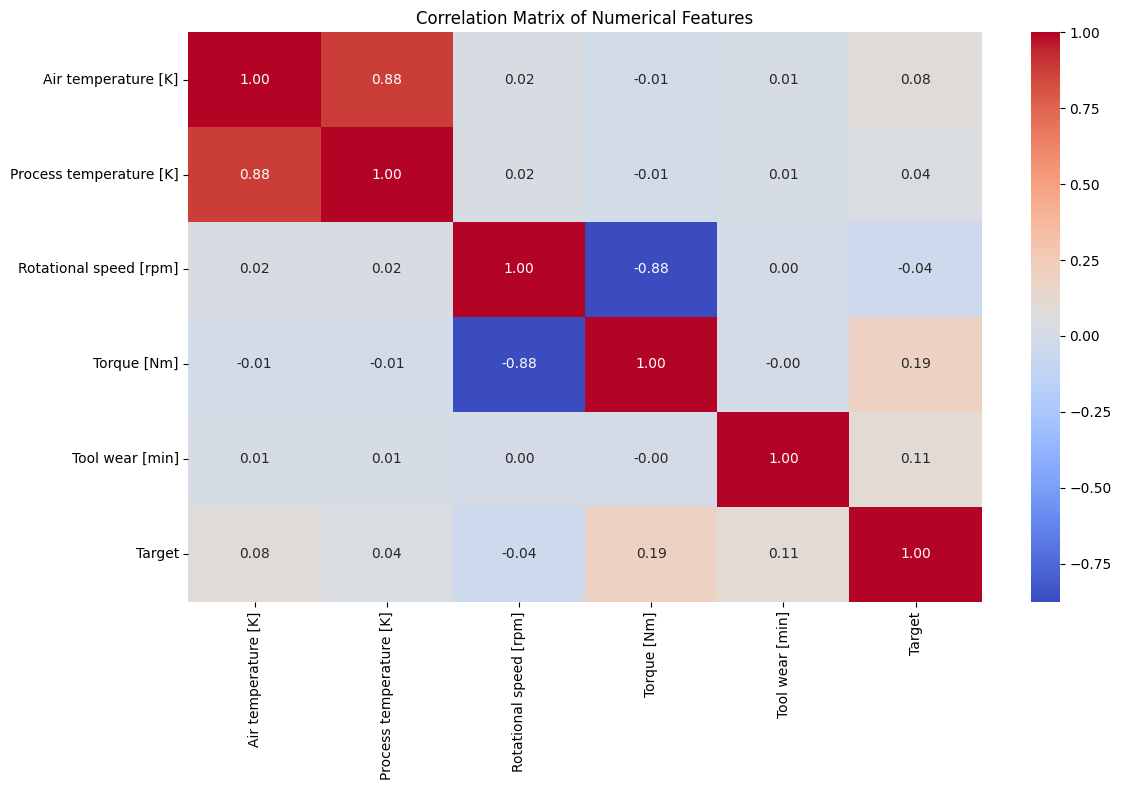

In [14]:
plt.figure(figsize=(12, 8))
correlation_matrix = df[numerical_cols + ['Target']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

based on the correlation matrix we will drop [ 'Rotational speed [rpm]','Process temperature [K]' ]

In [15]:
print("\nCorrelations with Target:")
print(correlation_matrix['Target'].sort_values(ascending=False))


Correlations with Target:
Target                     1.000000
Torque [Nm]                0.191321
Tool wear [min]            0.105448
Air temperature [K]        0.082556
Process temperature [K]    0.035946
Rotational speed [rpm]    -0.044188
Name: Target, dtype: float64


### Leakage Analysis
- **Failure Type**: Near-perfect mapping to `Target` (crosstab: 9643/9661 `Target` = 0 are "No Failure"; correlation: 0.959389), causing leakage.
- **Type**: Weak association (correlation: -0.005152). It’s a pre-event machine characteristic, not leakage.
- **Numerical Features**: Low correlations (e.g., `Torque [Nm]`: 0.191), indicating no leakage.
### Data Cleaning
- Excluded `UDI`, `Product ID` (non-predictive identifiers).
- One-hot encoded `Type` (`Type_M`, `Type_H`) and `Failure Type` (leaky model).
- Standardized numerical features using `StandardScaler`.(after splitting data to prevent leakage).
- No missing values found.

In [16]:
df_cleaned = df.drop(columns=['Process temperature [K]' ,'Failure Type', 'UDI', 'Product ID','Failure Type Binary' , 'Rotational speed [rpm]','Type_numeric'])
print("\nColumns in df_clean:", df_cleaned.columns.tolist())
print('\n')
print(df_cleaned.isnull().sum())


Columns in df_clean: ['Type', 'Air temperature [K]', 'Torque [Nm]', 'Tool wear [min]', 'Target']


Type                   0
Air temperature [K]    0
Torque [Nm]            0
Tool wear [min]        0
Target                 0
dtype: int64


In [17]:
numerical_cols = ['Air temperature [K]','Torque [Nm]', 'Tool wear [min]']

In [18]:
X = df_cleaned.drop('Target', axis=1)
y = df_cleaned['Target']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

X_train_clean = pd.get_dummies(X_train, columns=['Type'], drop_first=True)
X_test_clean = pd.get_dummies(X_test, columns=['Type'], drop_first=True)

scaler_clean = StandardScaler()


X_train_clean[numerical_cols] = scaler_clean.fit_transform(X_train_clean[numerical_cols])
X_test_clean[numerical_cols] = scaler_clean.transform(X_test_clean[numerical_cols])

In [20]:
X_train_clean.head()

,Air temperature [K],Torque [Nm],Tool wear [min],Type_L,Type_M
4058,0.998914,0.718305,-0.843997,False,True
1221,-1.505194,0.638456,0.382263,False,True
6895,0.498092,0.558607,0.460870,False,True
9863,-0.553633,1.626586,-0.372359,True,False
8711,-1.455112,-1.128202,-0.906882,True,False


In [21]:
X_test_clean.head()

,Air temperature [K],Torque [Nm],Tool wear [min],Type_L,Type_M
2997,0.247681,2.265378,0.712410,True,False
4871,1.850310,0.009646,0.429427,True,False
3858,1.249324,-0.239882,1.592802,True,False
951,-2.206344,-0.419543,-0.749670,False,False
6463,0.247681,2.035812,-0.089376,False,False


In [22]:
df_with_leakage = df.drop(columns=['Process temperature [K]' ,'UDI', 'Product ID','Failure Type Binary','Rotational speed [rpm]','Type_numeric'])

X_leak = df_with_leakage.drop('Target', axis=1)
y_leak = df_with_leakage['Target']

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_leak, y_leak, test_size=0.2, random_state=42,stratify=y_leak)
x_train_l = pd.get_dummies(X_train_l, columns=['Type','Failure Type'], drop_first=True)
x_test_l = pd.get_dummies(X_test_l, columns=['Type','Failure Type'], drop_first=True)

scaler_leak = StandardScaler()
x_train_l[numerical_cols] = scaler_leak.fit_transform(x_train_l[numerical_cols])
x_test_l[numerical_cols] = scaler_leak.transform(x_test_l[numerical_cols])

In [23]:
x_train_l.head()

,Air temperature [K],Torque [Nm],Tool wear [min],Type_L,Type_M,Failure Type_No Failure,Failure Type_Overstrain Failure,Failure Type_Power Failure,Failure Type_Random Failures,Failure Type_Tool Wear Failure
4058,0.998914,0.718305,-0.843997,False,True,True,False,False,False,False
1221,-1.505194,0.638456,0.382263,False,True,False,False,False,True,False
6895,0.498092,0.558607,0.460870,False,True,True,False,False,False,False
9863,-0.553633,1.626586,-0.372359,True,False,True,False,False,False,False
8711,-1.455112,-1.128202,-0.906882,True,False,True,False,False,False,False


In [24]:
x_test_l.head()

,Air temperature [K],Torque [Nm],Tool wear [min],Type_L,Type_M,Failure Type_No Failure,Failure Type_Overstrain Failure,Failure Type_Power Failure,Failure Type_Random Failures,Failure Type_Tool Wear Failure
2997,0.247681,2.265378,0.712410,True,False,True,False,False,False,False
4871,1.850310,0.009646,0.429427,True,False,True,False,False,False,False
3858,1.249324,-0.239882,1.592802,True,False,True,False,False,False,False
951,-2.206344,-0.419543,-0.749670,False,False,True,False,False,False,False
6463,0.247681,2.035812,-0.089376,False,False,True,False,False,False,False


In [25]:
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train_l, y_train_l)

importances = pd.Series(rf.feature_importances_, index=x_train_l.columns).sort_values(ascending=False)
print("\nFeature Importances from Random Forest:")
print(importances)


Feature Importances from Random Forest:
Failure Type_No Failure            0.590842
Failure Type_Power Failure         0.132813
Failure Type_Overstrain Failure    0.105532
Torque [Nm]                        0.053685
Failure Type_Tool Wear Failure     0.050939
Failure Type_Random Failures       0.029817
Tool wear [min]                    0.018611
Air temperature [K]                0.015246
Type_M                             0.001288
Type_L                             0.001226
dtype: float64


In [26]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_clean, y_train)

importances = pd.Series(rf.feature_importances_, index=X_train_clean.columns).sort_values(ascending=False)
print("\nFeature Importances from Random Forest:")
print(importances)


Feature Importances from Random Forest:
Torque [Nm]            0.558706
Tool wear [min]        0.250199
Air temperature [K]    0.161491
Type_L                 0.018142
Type_M                 0.011463
dtype: float64


### Part 4: Data Leakage Detection Techniques (Bonus)

#### 1. Correlation and Crosstab Analysis
- **Description**: This technique involves computing correlations between features and the target variable or creating crosstabs to examine the distribution of target values across feature categories. High correlations (e.g., >0.9) or near-perfect mappings in crosstabs (e.g., 100% or 0% proportions) indicate potential leakage.


#### 2. Random Forest Feature Importance Analysis
- **Description**: This technique uses a Random Forest Classifier to compute feature importances, . Features with  high importances  may indicate leakage, .


#### Limitations of Detection Techniques
- **Correlation and Crosstab Analysis**:
  -  May miss leakage in features with non-linear relationships to the target.
  -  Crosstabs are less effective for continuous features (e.g., `Torque [Nm]`).
  -  Requires understanding whether high correlations are legitimate (e.g., `Torque` as a predictor) or leakage (e.g., `Failure Type`).
- **Random Forest Feature Importance Analysis**:
  - High importance for legitimate predictors (e.g., `Torque` ) may be mistaken for leakage without domain knowledge.
  - **Overfitting Risk**: In small datasets, Random Forest may overfit.
  

In [27]:
# Model without leakage
lr = LogisticRegression(max_iter=1000,random_state=42)
lr.fit(X_train_clean, y_train)
nb = GaussianNB()
nb.fit(X_train_clean, y_train)

# Model with leakage
lr_leak = LogisticRegression(max_iter=1000,random_state=42)
lr_leak.fit(x_train_l, y_train_l)
nb_leak = GaussianNB()
nb_leak.fit(x_train_l, y_train_l)

GaussianNB()

In [ ]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

def formatted_evaluation(model, X_test, y_test, name):
    print(f"\n{name}")
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(tabulate([["Accuracy", acc],
                    ["Precision", prec],
                    ["Recall", rec],
                    ["F1 Score", f1]],
                   headers=["Metric", "Value"], tablefmt="fancy_grid", floatfmt=".4f"))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(tabulate(cm, headers=["Pred 0", "Pred 1"], showindex=["Actual 0", "Actual 1"], tablefmt="fancy_grid"))

    print("\nClassification Report:")
    report = classification_report(y_test, y_pred, output_dict=True)
    report_table = []

    for label in ['0', '1', 'accuracy', 'macro avg', 'weighted avg']:
        if label == 'accuracy':
            report_table.append([label, f"{report[label]:.2f}", "", "", ""])
        else:
            report_table.append([label] + [f"{report[label][metric]:.2f}" for metric in ['precision', 'recall', 'f1-score', 'support']])

    print(tabulate(report_table,
                   headers=["Class", "Precision", "Recall", "F1-Score", "Support"],
                   tablefmt="fancy_grid"))

In [ ]:
print("Without Leakage:")

formatted_evaluation(lr, X_test_clean, y_test, "🔹 Logistic Regression")
formatted_evaluation(nb, X_test_clean, y_test, "🔹 Naive Bayes")

Without Leakage:

🔹 Logistic Regression
╒═══════════╤═════════╕
│ Metric    │   Value │
╞═══════════╪═════════╡
│ Accuracy  │  0.9665 │
├───────────┼─────────┤
│ Precision │  0.6667 │
├───────────┼─────────┤
│ Recall    │  0.0294 │
├───────────┼─────────┤
│ F1 Score  │  0.0563 │
╘═══════════╧═════════╛

Confusion Matrix:
╒══════════╤══════════╤══════════╕
│          │   Pred 0 │   Pred 1 │
╞══════════╪══════════╪══════════╡
│ Actual 0 │     1931 │        1 │
├──────────┼──────────┼──────────┤
│ Actual 1 │       66 │        2 │
╘══════════╧══════════╧══════════╛

Classification Report:
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Class        │   Precision │ Recall   │ F1-Score   │ Support   │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0            │        0.97 │ 1.00     │ 0.98       │ 1932.00   │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ 1            │        0.67 │ 0.03     │ 0.06       │ 68.00     │
├─────

In [ ]:
print("with Leakage:")

formatted_evaluation(lr_leak, x_test_l, y_test_l, "🔹 Logistic Regression")
formatted_evaluation(nb_leak, x_test_l, y_test_l, "🔹 Naive Bayes")

with Leakage:

🔹 Logistic Regression
╒═══════════╤═════════╕
│ Metric    │   Value │
╞═══════════╪═════════╡
│ Accuracy  │  0.9990 │
├───────────┼─────────┤
│ Precision │  1.0000 │
├───────────┼─────────┤
│ Recall    │  0.9706 │
├───────────┼─────────┤
│ F1 Score  │  0.9851 │
╘═══════════╧═════════╛

Confusion Matrix:
╒══════════╤══════════╤══════════╕
│          │   Pred 0 │   Pred 1 │
╞══════════╪══════════╪══════════╡
│ Actual 0 │     1932 │        0 │
├──────────┼──────────┼──────────┤
│ Actual 1 │        2 │       66 │
╘══════════╧══════════╧══════════╛

Classification Report:
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Class        │   Precision │ Recall   │ F1-Score   │ Support   │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0            │           1 │ 1.00     │ 1.00       │ 1932.00   │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ 1            │           1 │ 0.97     │ 0.99       │ 68.00     │
├────────

### Model Performance Comparison
- **Clean Models** (Logistic Regression, Naive Bayes):
  - Accuracy 0.966, but very low recall (0.03–0.04) and F1-score (0.06–0.08) for failures (`Target` = 1).
  - Reflects the imbalanced dataset (9661:339) and absence of leakage, making failure prediction challenging.
- **Leaky Models** (including `Failure Type`):
  - Near-perfect metrics (accuracy ~0.999, recall ~0.971, F1 ~0.985).
  - `Failure Type` directly reveals `Target` (correlation: 0.959389), causing unrealistic performance.
- **SMOTE (Clean)**:
  - Lower accuracy (0.734–0.76) but higher recall (0.765–0.779) and F1 (~0.166–0.180), improving failure detection.
- **SMOTE (leakage)**:
  - Near-perfect metrics (accuracy ~0.999, recall ~0.971, F1 ~0.98).
  - `Failure Type` directly reveals `Target` (correlation: 0.959389), causing unrealistic performance.


In [ ]:
# Apply SMOTE to training data (without leakage)
smote = SMOTE(random_state=42)
X_train_clean_smote, y_train_clean_smote = smote.fit_resample(X_train_clean, y_train)

In [ ]:
lr_smote = LogisticRegression(max_iter=1000)
lr_smote.fit(X_train_clean_smote, y_train_clean_smote)

formatted_evaluation(lr_smote, X_test_clean, y_test, "🔹 Logistic Regression + SMOTE (No Leakage)")


🔹 Logistic Regression + SMOTE (No Leakage)
╒═══════════╤═════════╕
│ Metric    │   Value │
╞═══════════╪═════════╡
│ Accuracy  │  0.7340 │
├───────────┼─────────┤
│ Precision │  0.0930 │
├───────────┼─────────┤
│ Recall    │  0.7794 │
├───────────┼─────────┤
│ F1 Score  │  0.1661 │
╘═══════════╧═════════╛

Confusion Matrix:
╒══════════╤══════════╤══════════╕
│          │   Pred 0 │   Pred 1 │
╞══════════╪══════════╪══════════╡
│ Actual 0 │     1415 │      517 │
├──────────┼──────────┼──────────┤
│ Actual 1 │       15 │       53 │
╘══════════╧══════════╧══════════╛

Classification Report:
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Class        │   Precision │ Recall   │ F1-Score   │ Support   │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0            │        0.99 │ 0.73     │ 0.84       │ 1932.00   │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ 1            │        0.09 │ 0.78     │ 0.17       │ 68.00     │
├─

In [ ]:
nb_smote = GaussianNB()
nb_smote.fit(X_train_clean_smote, y_train_clean_smote)
formatted_evaluation(nb_smote, X_test_clean, y_test, "🔹 Naive Bayes + SMOTE (No Leakage)")


🔹 Naive Bayes + SMOTE (No Leakage)
╒═══════════╤═════════╕
│ Metric    │   Value │
╞═══════════╪═════════╡
│ Accuracy  │  0.7625 │
├───────────┼─────────┤
│ Precision │  0.1018 │
├───────────┼─────────┤
│ Recall    │  0.7647 │
├───────────┼─────────┤
│ F1 Score  │  0.1796 │
╘═══════════╧═════════╛

Confusion Matrix:
╒══════════╤══════════╤══════════╕
│          │   Pred 0 │   Pred 1 │
╞══════════╪══════════╪══════════╡
│ Actual 0 │     1473 │      459 │
├──────────┼──────────┼──────────┤
│ Actual 1 │       16 │       52 │
╘══════════╧══════════╧══════════╛

Classification Report:
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Class        │   Precision │ Recall   │ F1-Score   │ Support   │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0            │        0.99 │ 0.76     │ 0.86       │ 1932.00   │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ 1            │        0.1  │ 0.76     │ 0.18       │ 68.00     │
├─────────

In [ ]:
# Apply SMOTE to training data (with leakage)
smote_leak = SMOTE(random_state=42)
x_train_l_smote, y_train_l_smote = smote_leak.fit_resample(x_train_l, y_train_l)

In [ ]:
lr_leak_smote = LogisticRegression(max_iter=1000)
lr_leak_smote.fit(x_train_l_smote, y_train_l_smote)
formatted_evaluation(lr_leak_smote, x_test_l, y_test_l, "🔹 Logistic Regression + SMOTE (With Leakage)")


🔹 Logistic Regression + SMOTE (With Leakage)
╒═══════════╤═════════╕
│ Metric    │   Value │
╞═══════════╪═════════╡
│ Accuracy  │  0.9985 │
├───────────┼─────────┤
│ Precision │  0.9851 │
├───────────┼─────────┤
│ Recall    │  0.9706 │
├───────────┼─────────┤
│ F1 Score  │  0.9778 │
╘═══════════╧═════════╛

Confusion Matrix:
╒══════════╤══════════╤══════════╕
│          │   Pred 0 │   Pred 1 │
╞══════════╪══════════╪══════════╡
│ Actual 0 │     1931 │        1 │
├──────────┼──────────┼──────────┤
│ Actual 1 │        2 │       66 │
╘══════════╧══════════╧══════════╛

Classification Report:
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Class        │   Precision │ Recall   │ F1-Score   │ Support   │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0            │        1    │ 1.00     │ 1.00       │ 1932.00   │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ 1            │        0.99 │ 0.97     │ 0.98       │ 68.00     │


In [ ]:
nb_leak_smote = GaussianNB()
nb_leak_smote.fit(x_train_l_smote, y_train_l_smote)
formatted_evaluation(nb_leak_smote, x_test_l, y_test_l, "🔹 Naive Bayes + SMOTE (With Leakage)")


🔹 Naive Bayes + SMOTE (With Leakage)
╒═══════════╤═════════╕
│ Metric    │   Value │
╞═══════════╪═════════╡
│ Accuracy  │  0.9990 │
├───────────┼─────────┤
│ Precision │  1.0000 │
├───────────┼─────────┤
│ Recall    │  0.9706 │
├───────────┼─────────┤
│ F1 Score  │  0.9851 │
╘═══════════╧═════════╛

Confusion Matrix:
╒══════════╤══════════╤══════════╕
│          │   Pred 0 │   Pred 1 │
╞══════════╪══════════╪══════════╡
│ Actual 0 │     1932 │        0 │
├──────────┼──────────┼──────────┤
│ Actual 1 │        2 │       66 │
╘══════════╧══════════╧══════════╛

Classification Report:
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Class        │   Precision │ Recall   │ F1-Score   │ Support   │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0            │           1 │ 1.00     │ 1.00       │ 1932.00   │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ 1            │           1 │ 0.97     │ 0.99       │ 68.00     │
├───────